In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages databricks:spark-deep-learning:1.1.0-spark2.3-s_2.11 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

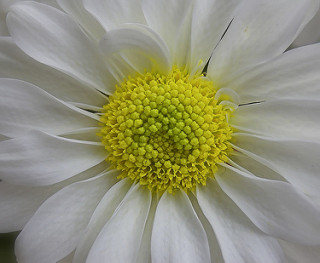

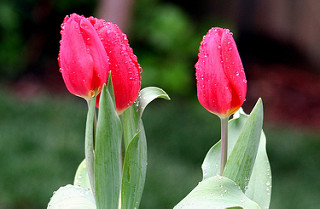

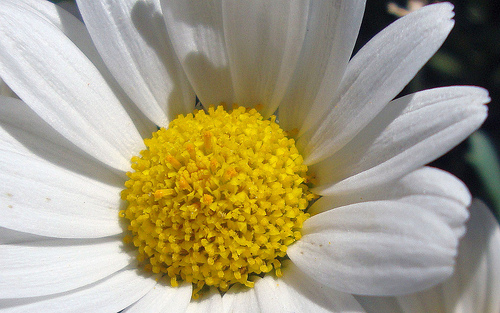

In [3]:
# collect all .png files in working dir
fs = !ls flower_photos/sample/*.jpg


import IPython.display as dp

# create list of image objects
images = []
for ea in fs:
    images.append(dp.Image(filename=ea, format='png'))

# display all images
for ea in images:
    dp.display_png(ea)

In [4]:
from pyspark.ml.image import ImageSchema
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")

In [5]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/Users/favi...|
|[file:/Users/favi...|
|[file:/Users/favi...|
+--------------------+



In [8]:
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from sparkdl.image import imageIO

tulips_df = ImageSchema.readImages("flower_photos/tulips").withColumn("label", lit(1))
daisy_df = imageIO.readImagesWithCustomFn("flower_photos/daisy", decode_f=imageIO.PIL_decode).withColumn("label", lit(0))
tulips_train, tulips_test, _ = tulips_df.randomSplit([0.02, 0.02, 0.96])  # use larger training sets (e.g. [0.6, 0.4] for getting more images)
daisy_train, daisy_test, _ = daisy_df.randomSplit([0.02, 0.02, 0.96])     # use larger training sets (e.g. [0.6, 0.4] for getting more images)
train_df = tulips_train.unionAll(daisy_train)
test_df = tulips_test.unionAll(daisy_test)

# Under the hood, each of the partitions is fully loaded in memory, which may be expensive.
# This ensure that each of the paritions has a small size.
train_df = train_df.repartition(100)
test_df = test_df.repartition(100)

In [9]:
train_df.count()

39

In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tested_df = p_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(tested_df.select("prediction", "label"))))

Test set accuracy = 0.9696969696969697


In [12]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
from pyspark.sql.functions import *
from pyspark.sql.types import *

def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

df = tested_df.withColumn("p", take_one(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p - label)"), ascending=False)
wrong_df.select("image.origin", "p", "label").show(10)

+--------------------+------------------+-----+
|              origin|                 p|label|
+--------------------+------------------+-----+
|file:/Users/favio...|0.8029292603616205|    0|
|file:/Users/favio...|0.4664013411419887|    0|
|file:/Users/favio...|0.6467587273888932|    1|
|file:/Users/favio...|0.7720408167288096|    1|
|file:/Users/favio...|0.1939600188102001|    0|
|file:/Users/favio...|0.8238945575958269|    1|
|file:/Users/favio...|0.1592276915689893|    0|
|file:/Users/favio...|0.8438853333873721|    1|
|file:/Users/favio...|0.8561534519536611|    1|
|file:/Users/favio...|0.8713374498016112|    1|
+--------------------+------------------+-----+
only showing top 10 rows



In [13]:
from sparkdl import DeepImagePredictor
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")

predictor = DeepImagePredictor(inputCol="image", outputCol="predicted_labels", modelName="InceptionV3", decodePredictions=True, topK=10)
predictions_df = predictor.transform(image_df)

INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [14]:
predictions_df.select("predicted_labels").show(truncate=False,n=3)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|predicted_labels                                                                                                                                                                                                                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
df = p_model.transform(image_df)

In [16]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [17]:
def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

In [18]:
# 100930342_92e8746431_n.jpg not a daisy
df.select("image.origin",(1-take_one(df.probability)).alias("p_daisy")).show(truncate=False)

+------------------------------------------------------------------------------------------------------+-------------------+
|origin                                                                                                |p_daisy            |
+------------------------------------------------------------------------------------------------------+-------------------+
|file:/Users/faviovazquez/Presentations/ODSC-India/Code/flower_photos/sample/100930342_92e8746431_n.jpg|0.14694016477368255|
|file:/Users/faviovazquez/Presentations/ODSC-India/Code/flower_photos/sample/10140303196_b88d3d6cec.jpg|0.9132582168414303 |
|file:/Users/faviovazquez/Presentations/ODSC-India/Code/flower_photos/sample/100080576_f52e8ee070_n.jpg|0.898220709350876  |
+------------------------------------------------------------------------------------------------------+-------------------+



##Â For Keras users

For applying Keras models in a distributed manner using Spark, KerasImageFileTransformer works on TensorFlow-backed Keras models. It 

- Internally creates a DataFrame containing a column of images by applying the user-specified image loading and processing function to the input DataFrame containing a column of image URIs
- Loads a Keras model from the given model file path
- Applies the model to the image DataFrame

To use the transformer, we first need to have a Keras model stored as a file. For this notebook we'll just save the Keras built-in InceptionV3 model instead of training one.

In [19]:
from keras.applications import InceptionV3

model = InceptionV3(weights="imagenet")
model.save('model-full.h5')  # saves to the local filesystem

In [20]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from pyspark.sql.types import StringType
from sparkdl import KerasImageFileTransformer

def loadAndPreprocessKerasInceptionV3(uri):
  # this is a typical way to load and prep images in keras
    image = img_to_array(load_img(uri, target_size=(299, 299)))  # image dimensions for InceptionV3
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)

transformer = KerasImageFileTransformer(inputCol="uri", outputCol="predictions",
                                        modelFile='model-full.h5',  # local file path for model
                                        imageLoader=loadAndPreprocessKerasInceptionV3,
                                        outputMode="vector")

In [21]:
fs = !ls flower_photos/sample/*.jpg

In [22]:
fs

['flower_photos/sample/100080576_f52e8ee070_n.jpg',
 'flower_photos/sample/100930342_92e8746431_n.jpg',
 'flower_photos/sample/10140303196_b88d3d6cec.jpg']

In [24]:
uri_df = spark.createDataFrame(fs, StringType()).toDF("uri")

In [25]:
uri_df.show()

+--------------------+
|                 uri|
+--------------------+
|flower_photos/sam...|
|flower_photos/sam...|
|flower_photos/sam...|
+--------------------+



In [26]:
keras_pred_df = transformer.transform(uri_df)

/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [27]:
keras_pred_df.select("uri", "predictions").show()

+--------------------+--------------------+
|                 uri|         predictions|
+--------------------+--------------------+
|flower_photos/sam...|[7.43818964110687...|
|flower_photos/sam...|[3.56566015398129...|
|flower_photos/sam...|[3.49412839568685...|
+--------------------+--------------------+



In [29]:
from sparkdl import KerasTransformer
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Generate random input data
num_features = 10
num_examples = 100
input_data = [{"features" : np.random.randn(num_features).astype(float).tolist()} for i in range(num_examples)]
schema = StructType([ StructField("features", ArrayType(FloatType()), True)])
input_df = spark.createDataFrame(input_data, schema)

# Create and save a single-hidden-layer Keras model for binary classification
# NOTE: In a typical workflow, we'd train the model before exporting it to disk,
# but we skip that step here for brevity
model = Sequential()
model.add(Dense(units=20, input_shape=[num_features], activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model_path = "simple-binary-classification"
model.save(model_path)

# Create transformer and apply it to our input data
transformer = KerasTransformer(inputCol="features", outputCol="predictions", modelFile=model_path)
final_df = transformer.transform(input_df)

INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
INFO:tensorflow:Froze 0 variables.


/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 0 variables to const ops.


In [30]:
final_df.show()

+------------+--------------------+
| predictions|            features|
+------------+--------------------+
| [0.4677379]|[-1.6701169, 0.68...|
| [0.6061979]|[-1.4842298, 1.36...|
|[0.63828146]|[-0.62256587, 0.9...|
|[0.44420123]|[1.3049325, -0.06...|
|[0.38408118]|[-0.9042726, -0.4...|
| [0.4333322]|[0.9383539, 0.235...|
|[0.80039924]|[0.83776176, 1.20...|
| [0.5302721]|[-0.291789, 0.713...|
|[0.23145334]|[-0.4575898, -0.9...|
|  [0.400105]|[-1.6929305, -0.3...|
|[0.28454083]|[0.60204244, 0.66...|
| [0.7779815]|[0.18684813, 0.10...|
|[0.46045297]|[-1.4385461, 0.13...|
| [0.7210131]|[1.8419535, -1.68...|
|[0.49123466]|[-0.7052188, -0.1...|
| [0.5616104]|[0.675452, 1.5419...|
| [0.2705766]|[-0.9686563, -0.5...|
|[0.47616282]|[-1.7703608, 1.89...|
| [0.5104736]|[1.0606184, -0.28...|
| [0.2564718]|[0.93379587, -0.4...|
+------------+--------------------+
only showing top 20 rows



In [31]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

registerKerasImageUDF("inceptionV3_udf", InceptionV3(weights="imagenet"))

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [32]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

def keras_load_img(fpath):
    from keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    img = load_img(fpath, target_size=(299, 299))
    return img_to_array(img).astype(np.uint8)

registerKerasImageUDF("inceptionV3_udf_with_preprocessing", InceptionV3(weights="imagenet"), keras_load_img)

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [33]:
from pyspark.ml.image import ImageSchema

image_df = ImageSchema.readImages("flower_photos/sample/")
image_df.registerTempTable("sample_images")

In [34]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/Users/favi...|
|[file:/Users/favi...|
|[file:/Users/favi...|
+--------------------+



In [35]:
spark.sql("SELECT inceptionV3_udf_with_preprocessing(image) as predictions from sample_images").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------